In [1]:
!pip install transformers accelerate torch --quiet
!pip install pandas matplotlib --quiet

import torch
import pandas as pd
import matplotlib.pyplot as plt

print("Setup OK!")


Setup OK!


In [1]:
import torch
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU name:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("GPU name error:", e)
else:
    # extra diagnostic if GPU is not enabled
    try:
        !nvidia-smi
    except Exception as e:
        print("nvidia-smi error:", e)


torch version: 2.9.0+cu126
CUDA available: True
GPU name: Tesla T4


In [5]:
from huggingface_hub import login

print("Paste your HF token here when asked (READ token).")
login()


Paste your HF token here when asked (READ token).


In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "EleutherAI/gpt-neo-1.3B"

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")

print("Model loaded successfully!")


Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Model loaded successfully!


In [7]:
# Warmup + single generate test (for GPT-Neo)
import time, torch

prompt = "Hello, how are you today?"
device = next(model.parameters()).device
print("Using device:", device)
print("Tokenizer/model:", type(tokenizer).__name__, type(model).__name__)

# If tokenizer has no pad_token (common for GPT2-style), set it to eos
if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set tokenizer.pad_token = tokenizer.eos_token")

# prepare batch=1
inputs = tokenizer([prompt], return_tensors="pt", padding=True).to(device)

# Warmup
_ = model.generate(**inputs, max_new_tokens=8)

# Timed generate
if torch.cuda.is_available(): torch.cuda.synchronize()
t0 = time.perf_counter()
out = model.generate(**inputs, max_new_tokens=8)
if torch.cuda.is_available(): torch.cuda.synchronize()
t1 = time.perf_counter()

print("Warmup+generate time (sec) for 8 tokens, batch=1:", round(t1 - t0, 4))
print("Output shape:", out.shape)
print("Decoded (first 300 chars):")
print(tokenizer.decode(out[0], skip_special_tokens=True)[:300])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Using device: cuda:0
Tokenizer/model: GPT2TokenizerFast GPTNeoForCausalLM
Set tokenizer.pad_token = tokenizer.eos_token


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Warmup+generate time (sec) for 8 tokens, batch=1: 0.5529
Output shape: torch.Size([1, 15])
Decoded (first 300 chars):
Hello, how are you today?
I'm here with my friend



In [8]:
# Full benchmark (runs batches and saves results)
import numpy as np, pandas as pd, gc, time, torch

# ensure pad token exists
if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token

def benchmark_token_generation(tokenizer, model, prompt="Hello, how are you?",
                               batch_sizes=[1,8,32,128], new_tokens=1, repeats=3, warmup=1):
    results = []
    device = next(model.parameters()).device

    for bs in batch_sizes:
        try:
            print(f"\n--- Running batch size {bs} ---")
            inputs = [prompt] * bs
            enc = tokenizer(inputs, return_tensors="pt", padding=True).to(device)

            # warmup
            for _ in range(warmup):
                _ = model.generate(**enc, max_new_tokens=new_tokens)

            latencies = []
            for r in range(repeats):
                if torch.cuda.is_available(): torch.cuda.synchronize()
                t0 = time.perf_counter()
                _ = model.generate(**enc, max_new_tokens=new_tokens)
                if torch.cuda.is_available(): torch.cuda.synchronize()
                t1 = time.perf_counter()
                total_time = t1 - t0
                per_token_latency = total_time / max(1, new_tokens)
                throughput = (bs * new_tokens) / total_time
                latencies.append(per_token_latency)
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()

            results.append({
                "batch_size": bs,
                "mean_latency_s_per_token": float(np.mean(latencies)),
                "std_latency": float(np.std(latencies)),
                "mean_throughput_tokens_per_s": float(np.mean([(bs*new_tokens)/l for l in latencies])),
                "repeats": repeats
            })
            print(f"Completed batch {bs}")
        except Exception as e:
            print(f"Batch {bs} failed with error:", repr(e))
            break

    return pd.DataFrame(results)

# run benchmark
batch_sizes = [1, 8, 32, 128]
df = benchmark_token_generation(tokenizer, model, prompt="Hello, how are you?", batch_sizes=batch_sizes, new_tokens=1, repeats=3, warmup=1)

# save and show
df.to_csv("llama_benchmark_results.csv", index=False)
print("\nSaved results to llama_benchmark_results.csv")
print(df)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Running batch size 1 ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Completed batch 1

--- Running batch size 8 ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Completed batch 8

--- Running batch size 32 ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Completed batch 32

--- Running batch size 128 ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Completed batch 128

Saved results to llama_benchmark_results.csv
   batch_size  mean_latency_s_per_token  std_latency  \
0           1                  0.068758     0.010619   
1           8                  0.081288     0.011557   
2          32                  0.164010     0.008026   
3         128                  0.525638     0.014713   

   mean_throughput_tokens_per_s  repeats  
0                     14.869680        3  
1                    100.258107        3  
2                    195.565137        3  
3                    243.700763        3  


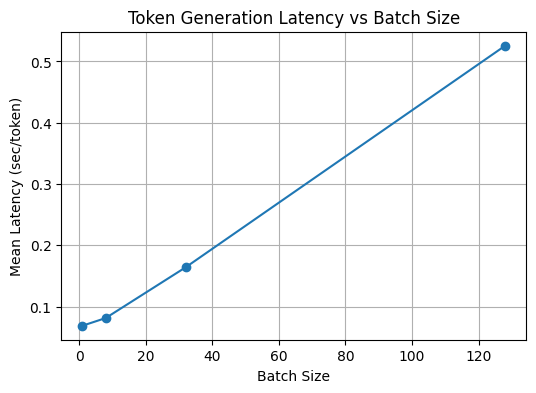

In [10]:
import matplotlib.pyplot as plt   # re-import

plt.figure(figsize=(6,4))
plt.plot(df["batch_size"], df["mean_latency_s_per_token"], marker='o')
plt.xlabel("Batch Size")
plt.ylabel("Mean Latency (sec/token)")
plt.title("Token Generation Latency vs Batch Size")
plt.grid(True)
plt.show()
